In [3]:
import os
import numpy as np
from astropy.table import Table
from astropy.io import fits

In [4]:
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
import corner as dfm
import matplotlib.patches as mpatches
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
# read GSWLC data: https://salims.pages.iu.edu/gswlc/#catalog-download
# data column details: https://salims.pages.iu.edu/gswlc/table2.pdf
#fgswlc = os.path.join(os.environ['GALPOPFM_DIR'], 'obs', 'GSWLC-M2.dat')
#gswlc = np.loadtxt(fgswlc, unpack=True)
gswlc = np.loadtxt('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/GSWLC-M2.dat', unpack = True)

In [6]:
logm = gswlc[9]
logsfr = gswlc[11]
logssfr = logsfr-logm
Av = gswlc[17]
A1500 = gswlc[13]
sdssmain = gswlc[23]
plateid = gswlc[2]
fiberid = gswlc[4]
mjd = gswlc[3]
photoid = gswlc[0]

In [7]:
has_Av = (Av != -99.) & (A1500 != -99.)
mlim = (logm > 10.)
sdss = (sdssmain == 1)

cuts = has_Av & mlim & sdss

is_q = (logsfr < logm - 11.5)
is_sf = (logsfr > logm - 11.5)

#selection = (logssfr > -3 * (logm - 9.5) - 10.)
#cuts = has_Av & selection

In [38]:
hdu = fits.open('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/gal_info_dr7_v5_2.fit')
tab = hdu[1].data
t = Table([tab['plateid'], tab['spectrotype'], tab['fiberid'], tab['Z'], tab['mjd'], tab['photoid']],
              names = ('plateID', 'spectrotype','fiberID','redshift', 'MJD', 'photoID'))
select = (t['spectrotype'] == 'GALAXY')
print 'number of spectra in catalog: ', len(select), 'number of galaxy spectra: ', np.sum(select)
tselect = t[select]

hdu_class = fits.open('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/gal_iclass_dr7_v5_2.fits')
classes = hdu_class[0].data
classes = classes[select]

hdu_indx = fits.open('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/gal_indx_dr7_v5_2.fit')
tab_indx = hdu_indx[1].data
t_indx = Table([tab_indx['plateid'],tab_indx['fiberid'],tab_indx['tauv_cont'],tab_indx['model_chisq']], names = ('plateID','fiberID','tauV','chisq'))
tindx = t_indx[select]

hdu_totsfr = fits.open('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/gal_totsfr_dr7_v5_2.fits')
#print hdu_totsfr[1].columns
tab_totsfr = hdu_totsfr[1].data
t_totsfr = Table([tab_totsfr['AVG'], tab_totsfr['MEDIAN']], names = ('sfravg','sfrmedian'))
ttotsfr= t_totsfr[select]

hdu_totlgm = fits.open('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/gal_totlgm_dr7_v5_2b.fit')
#print hdu_totlgm[1].columns
tab_totlgm = hdu_totlgm[1].data
t_totlgm = Table([tab_totlgm['AVG'], tab_totlgm['MEDIAN']], names = ('mavg','mmedian'))
ttotlgm= t_totlgm[select]

number of spectra in catalog:  927552 number of galaxy spectra:  925892


(-5, 2)

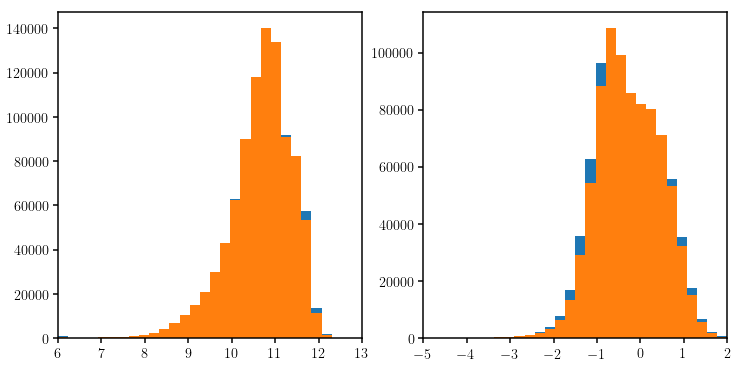

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12,6])
ax1.hist(ttotlgm['mavg'], bins = 30, range = [6,13])
ax1.hist(ttotlgm['mmedian'], bins = 30, range = [6,13])
ax1.set_xlim(6,13)
ax2.hist(ttotsfr['sfravg'], bins = 30, range = [-5,2])
ax2.hist(ttotsfr['sfrmedian'], bins = 30, range = [-5,2])
ax2.set_xlim(-5,2)

In [7]:
sdss_SF_z03 = np.logical_and(classes == 1, tselect['redshift'] < 0.3)
print 'number of SF galaxies with z < 0.3:', np.sum(sdss_SF_z03)

number of SF galaxies with z < 0.3: 202014


In [8]:
gswlc_SF_Av = []
mpajhu_SF_Av = []
for i in range(np.sum(sdss_SF_z03)):
    assert tindx['plateID'][sdss_SF_z03][i] == tselect['plateID'][sdss_SF_z03][i]
    assert tindx['fiberID'][sdss_SF_z03][i] == tselect['fiberID'][sdss_SF_z03][i]
    inGSWLC = np.logical_and(plateid == tselect['plateID'][sdss_SF_z03][i], fiberid == tselect['fiberID'][sdss_SF_z03][i])
    if np.sum(inGSWLC) == 1:
        gswlc_SF_Av.append(Av[inGSWLC])
        mpajhu_SF_Av.append(tindx['tauV'][sdss_SF_z03][i]*1.086)
    #elif np.sum(inGSWLC) == 0:
    #    print i, 'not in GSWLC??', tselect['plateID'][i], tselect['fiberID'][i]
    elif np.sum(inGSWLC) > 1:
        print 'need to match mjd too'
        inGSWLC2 = np.logical_and(inGSWLC, mjd == tselect['MJD'][sdss_SF_z03][i])
        if np.sum(inGSWLC2) == 1:
            gswlc_SF_Av.append(Av[inGSWLC2])
            mpajhu_SF_Av.append(tindx['tauV'][sdss_SF_z03][i]*1.086)
        elif np.sum(inGSWLC2) > 1:
            print 'problem matching'
print 'number of SF galaxies with z < 0.3 in both MAP-JHU and GSWLC-2: ', len(gswlc_SF_Av), len(mpajhu_SF_Av)

KeyboardInterrupt: 

In [46]:
gswlc_SF_Av = np.reshape(np.asarray(gswlc_SF_Av), (len(gswlc_SF_Av),))
mpajhu_SF_Av = np.asarray(mpajhu_SF_Av)

In [47]:
print gswlc_SF_Av[0:10], mpajhu_SF_Av[0:10]
print np.min(gswlc_SF_Av[0:10]), np.mean(gswlc_SF_Av[0:10]), np.median(gswlc_SF_Av[0:10]), np.max(gswlc_SF_Av[0:10])
print np.min(mpajhu_SF_Av[0:10]), np.mean(mpajhu_SF_Av[0:10]), np.median(mpajhu_SF_Av[0:10]), np.max(mpajhu_SF_Av[0:10])

[0.29  0.358 0.155 0.192 0.595 0.225 0.462 0.28  0.229 0.31 ] [0.03099965 0.82148172 2.23849287 2.00870892 1.71122358 1.60446346
 1.05924132 1.00207711 1.13319408 1.33591104]
0.155 0.3096 0.28500000000000003 0.595
0.030999653186649087 1.294579375287518 1.2345525562763213 2.238492871284485


(-1, 3)

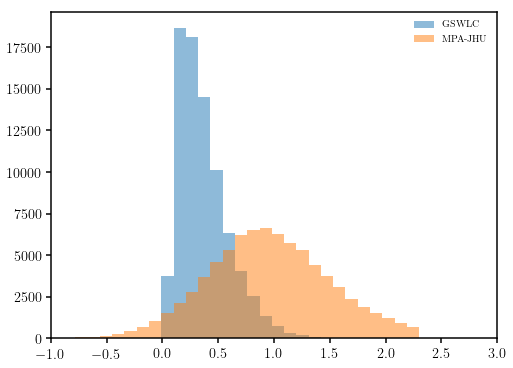

In [49]:
fig, ax = plt.subplots(1,1,figsize = [8,6])
ax.hist(gswlc_SF_Av, bins = 30, density = True, alpha = 0.5, range = [-1,2.3], label = 'GSWLC')
ax.hist(mpajhu_SF_Av, bins = 30, density = True, alpha = 0.5, range = [-1,2.3], label = 'MPA-JHU')
ax.legend()
ax.set_xlim(0,4)

In [24]:
import h5py as h5
f = h5.File('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/DATA/tinker_SDSS_centrals_M9.7.valueadd.hdf5','r')
av_nsa = f['AV'][:]
nsa_plateid = f['PLATE'][:]
nsa_fiberid = f['FIBERID'][:]
nsa_MJD = f['MJD'][:]
nsa_mass = np.log10(f['ms_tinker'][:])
nsa_ssfr = f['sfr_tinker'][:]
f.close()

In [45]:

print 'size GSWLC has AV:', np.sum(has_Av), 'size nsa:', len(av_nsa)

av_nsa_match = []
mass_nsa_match = []
ssfr_nsa_match = []
av_nsa_matchgswlc = []
av_gswlc = []
av_gswlc_matchnsa = []
av_mpajhu = []
mstar_mpajhu = []
sfr_mpajhu = []
gswlc_match_loc = []
gswlc_matchnsa_loc = []
for i in range(len(av_nsa)):
    inGSWLC = (plateid[has_Av] == nsa_plateid[i]) & (fiberid[has_Av] == nsa_fiberid[i]) & (mjd[has_Av] == nsa_MJD[i])
    inMPAJHU = (t['plateID'][:] == nsa_plateid[i]) & (t['fiberID'][:] == nsa_fiberid[i]) & (t['MJD'][:] == nsa_MJD[i])
    #if np.sum(inGSWLC) == 0 or np.sum(inMPAJHU) == 0:
        #print i, nsa_plateid[i], nsa_fiberid[i]
    #else:
    if np.sum(inGSWLC) > 1: print 'more than 1 match: ', np.sum(inGSWLC)
    if np.sum(inGSWLC) > 0 and np.sum(inMPAJHU) > 0:
        #print nsa_plateid[i], plateid[inGSWLC][0], tselect['plateID'][inMPAJHU][0]
        #print nsa_fiberid[i], fiberid[inGSWLC][0], tselect['fiberID'][inMPAJHU][0]
        av_gswlc.append(Av[has_Av][inGSWLC][0])
        av_gswlc_matchnsa.append(Av[has_Av][inGSWLC][0])
        gswlc_match_loc.append(np.where(inGSWLC)[0][0]) 
        gswlc_matchnsa_loc.append(np.where(inGSWLC)[0][0]) 
        av_nsa_match.append(av_nsa[i])
        av_nsa_matchgswlc.append(av_nsa[i])
        av_mpajhu.append(t_indx['tauV'][inMPAJHU][0]*1.086)
        mstar_mpajhu.append(t_totlgm['mmedian'][inMPAJHU][0])
        sfr_mpajhu.append(t_totsfr['sfrmedian'][inMPAJHU][0])
        ssfr_nsa_match.append(nsa_ssfr[i])
        mass_nsa_match.append(nsa_mass[i])
    elif np.sum(inGSWLC) > 0:
        av_gswlc_matchnsa.append(Av[has_Av][inGSWLC][0])
        gswlc_matchnsa_loc.append(np.where(inGSWLC)[0][0])
        av_nsa_matchgswlc.append(av_nsa[i])
    if i % 1000 == 0: print i
    #elif np.sum(inGSWLC) == 0:
    #    print i, 'not in GSWLC??', tselect['plateID'][i], tselect['fiberID'][i]
    
print 'number of galaxies from GSWLC in both MAP-JHU and Tinker NSA sample: ', len(gswlc_match_loc), len(av_nsa_match), len(av_gswlc), len(av_mpajhu)
print 'number of galaxies from GSWLC in just Tinker NSA sample: ', len(gswlc_matchnsa_loc), len(av_nsa_matchgswlc), len(av_gswlc_matchnsa)

av_gswlc = np.reshape(np.asarray(av_gswlc), (len(av_gswlc),))
av_gswlc_matchnsa = np.reshape(np.asarray(av_gswlc_matchnsa), (len(av_gswlc_matchnsa),))
av_mpajhu = np.asarray(av_mpajhu)
ssfr_mpajhu = sfr_mpajhu - mstar_mpajhu

size GSWLC has AV: 356140 size nsa: 12344
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
number of galaxies from GSWLC in both MAP-JHU and Tinker NSA sample:  5762 5762 5762 5762
number of galaxies from GSWLC in just Tinker NSA sample:  5769 5769 5769


NameError: name 'mass_mpajhu' is not defined

In [47]:
sfr_mpajhu = np.asarray(sfr_mpajhu)
mstar_mpajhu = np.asarray(mstar_mpajhu)
ssfr_mpajhu = sfr_mpajhu - mstar_mpajhu

(0, 4)

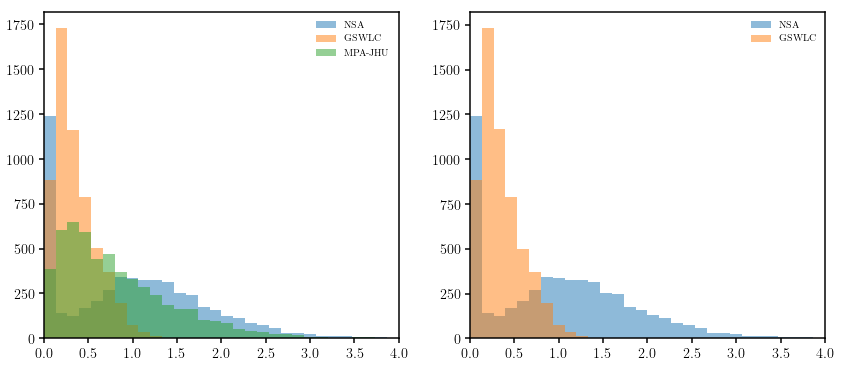

In [19]:

fig, (ax1, ax2) = plt.subplots(1,2,figsize = [14,6])
ax1.hist(av_nsa_match, bins = 30, alpha = 0.5, range = [0,4], label = 'NSA')
ax1.hist(av_gswlc, bins = 30, alpha = 0.5, range = [0,4], label = 'GSWLC')
ax1.hist(av_mpajhu, bins = 30, alpha = 0.5, range = [0,4], label = 'MPA-JHU')
ax1.legend()
ax1.set_xlim(0,4)
ax2.hist(av_nsa_matchgswlc, bins = 30, alpha = 0.5, range = [0,4], label = 'NSA')
ax2.hist(av_gswlc_matchnsa, bins = 30, alpha = 0.5, range = [0,4], label = 'GSWLC')
ax2.legend()
ax2.set_xlim(0,4)

-99.0 12.464 7.254 12.464 7.914 11.724
[-10.393 -12.605 -11.4   ... -10.083 -11.99  -11.19 ]


(-13.2, -9.0)

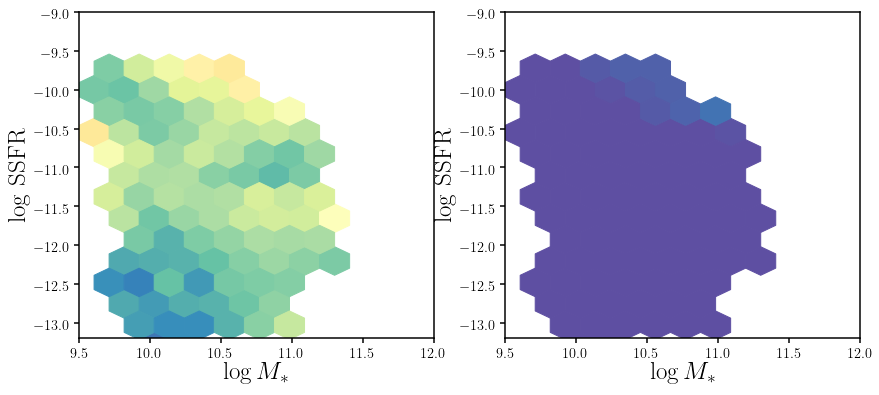

In [27]:

print np.min(logm), np.max(logm), np.min(logm[has_Av]), np.max(logm[has_Av]), np.min(logm[has_Av][gswlc_matchnsa_loc]), np.max(logm[has_Av][gswlc_matchnsa_loc])
print logssfr[has_Av][gswlc_matchnsa_loc]

fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.hexbin(logm[has_Av][gswlc_matchnsa_loc], logssfr[has_Av][gswlc_matchnsa_loc], C=A1500[has_Av][gswlc_matchnsa_loc], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=10, cmap='Spectral_r')
sub.set_xlim([9.5, 12.]) 
sub.set_ylabel(r'$\log$ SSFR', fontsize=25)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_ylim([-13.2, -9.])

sub = fig.add_subplot(122)
sub.hexbin(logm[has_Av][gswlc_matchnsa_loc], logssfr[has_Av][gswlc_matchnsa_loc], C=Av[has_Av][gswlc_matchnsa_loc], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=10, cmap='Spectral_r')
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_ylabel(r'$\log$ SSFR', fontsize=25)
sub.set_ylim([-13.2, -9.])

Text(11,-9.5,'MPA-JHU')

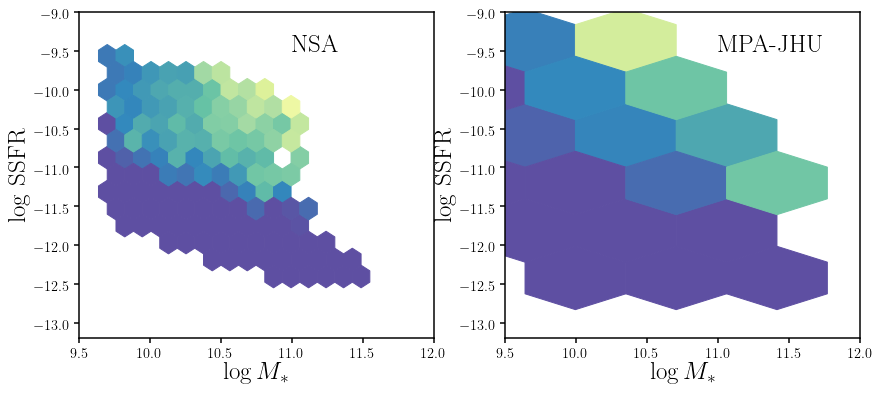

In [48]:
fig = plt.figure(figsize=(14,6))
sub = fig.add_subplot(121)
sub.hexbin(mass_nsa_match, ssfr_nsa_match, C=av_nsa_match, reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=10, cmap='Spectral_r')
sub.set_xlim([9.5, 12.]) 
sub.set_ylabel(r'$\log$ SSFR', fontsize=25)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_ylim([-13.2, -9.])
sub.text(11,-9.5, 'NSA', fontsize = 25)

sub = fig.add_subplot(122)
sub.hexbin(mstar_mpajhu, ssfr_mpajhu, C=av_mpajhu, reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=10, cmap='Spectral_r')
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_ylabel(r'$\log$ SSFR', fontsize=25)
sub.set_ylim([-13.2, -9.])
sub.text(11,-9.5, 'MPA-JHU', fontsize = 25)